<a href="https://colab.research.google.com/github/sully-vian/immorthon/blob/main/immorthon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Immorthon

In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
import pandas as pd

dicoDir = "dictionnaries/"

# par ordre croissant de taille
dicoNames = ["dico-ef.csv", "dico-mit.csv", "dico-alpha.csv"]
dicoPath = dicoDir + dicoNames[2]

# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
  !git clone https://github.com/sully-vian/immorthon.git
  dicoPath = "immorthon/" + dicoPath
else:
  dicoPath = "./" + dicoPath

# set pandas to print full strings
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(dicoPath, encoding="utf-8", on_bad_lines="error", na_filter=False)
df["text"] = "Define: " + df["word"] + "\n" + df["definition"]

# print line where word is none
(df[df["word"].isnull()])

# print line where word == "house"
print(df[df["word"] == "null"])

Cloning into 'immorthon'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 85 (delta 33), reused 54 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 5.34 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (33/33), done.
       word             definition                                 text
42576  null  having the value zero  Define: null\nhaving the value zero


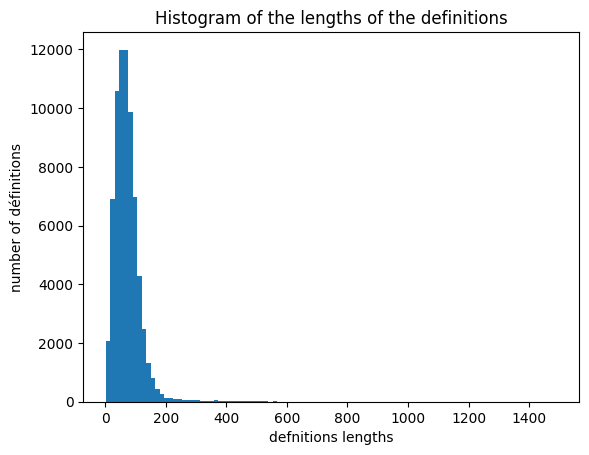

In [ ]:
import matplotlib.pyplot as plt

definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["text"]])
# séparer aléatoirement la data en train et test
splitDataset = dataset.train_test_split(test_size=0.1)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# par ordre croissant de taille
modelNames = [
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[0]
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(modelName)

def tokenize(examples):
    encoding = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=32
    )
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenizedDataset = splitDataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/63909 [00:00<?, ? examples/s]

Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-6-eb22fd972da1>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,3.747500
20,2.544300
30,2.430600
40,2.098000
50,2.122600
60,2.144000
70,1.933800
80,2.047200
90,1.977100
100,1.907500


TrainOutput(global_step=7989, training_loss=1.634183133643744, metrics={'train_runtime': 594.4139, 'train_samples_per_second': 107.516, 'train_steps_per_second': 13.44, 'total_flos': 521850438549504.0, 'train_loss': 1.634183133643744, 'epoch': 1.0})

In [1]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = f"Define: {prompt}\n"
    results = generator(fullPrompt, max_length=64, num_return_sequences=numDef, do_sample=True, temperature=0.7, truncation=True)
    return [result["generated_text"] for result in results]

for result in generate("dogoid", 3):
    print(result, end="\n\n")

NameError: name 'model' is not defined